In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scanpy.external as sce
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sc.settings.verbosity = 0             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=100, facecolor='white')

scanpy==1.10.1 anndata==0.10.7 umap==0.5.6 numpy==1.26.4 scipy==1.13.0 pandas==2.2.2 scikit-learn==1.4.2 statsmodels==0.14.2 igraph==0.11.5 pynndescent==0.5.12


In [3]:
adata = sc.read_10x_mtx(
    'bob_2/filtered_feature_bc_matrix/',  # the directory with the `.mtx` file
    var_names='gene_symbols',       # use gene symbols for the variable names (variables-axis index)
    cache=True)

adata.var_names_make_unique()

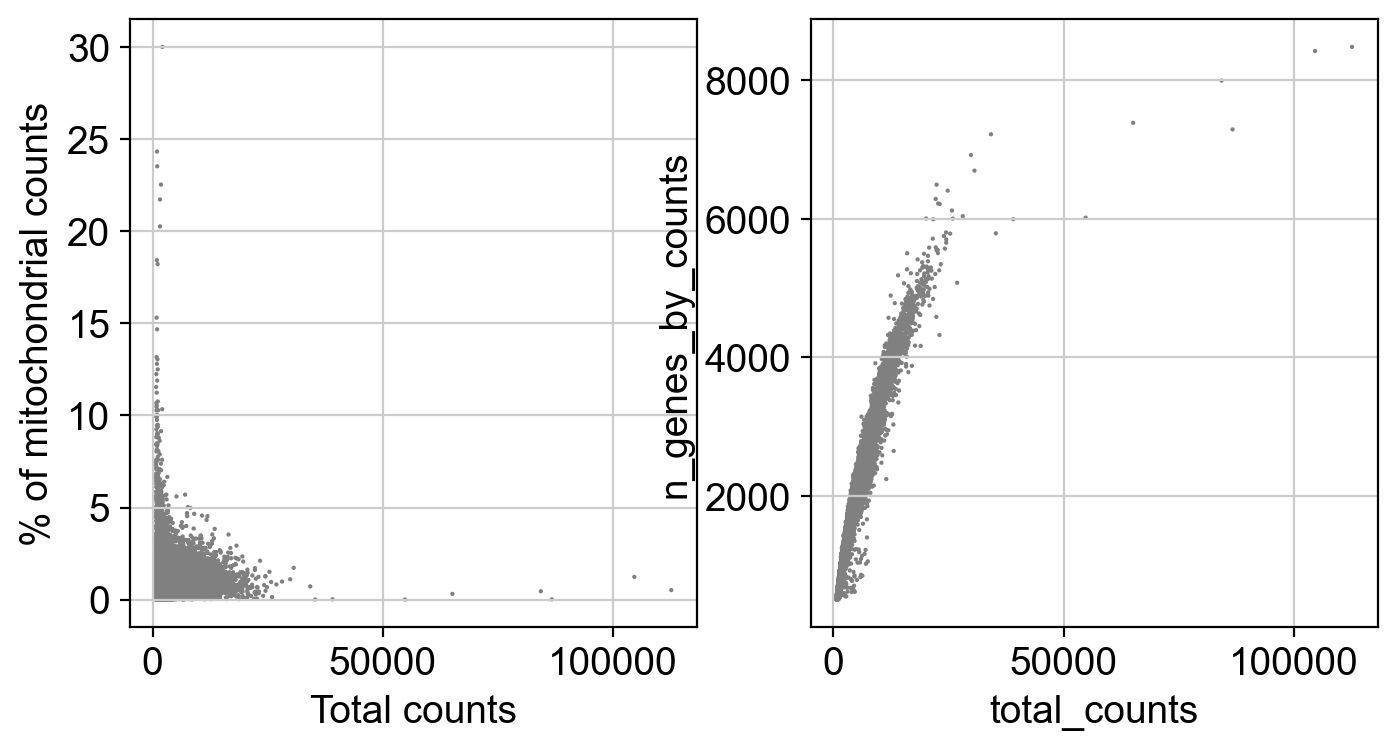

<Figure size 400x400 with 0 Axes>

In [4]:
# Filter cells and genes with low counts
sc.pp.filter_cells(adata, min_genes=500)
sc.pp.filter_genes(adata, min_cells=3)

# Filter cells with high fraction of mitochondrial genes
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
def plot_mt(adata):
    fig, ax = plt.subplots(1, 2, figsize=[8, 4])
    sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', show=False, ax=ax[0])
    ax[0].set_xlabel("Total counts")
    ax[0].set_ylabel("% of mitochondrial counts")
    sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', ax=ax[1])
    plt.tight_layout()
    plt.show()

plot_mt(adata)

In [5]:
adata = adata[adata.obs.n_genes_by_counts < 6000, :]
adata = adata[adata.obs.pct_counts_mt < 10, :]

# Remove doublets
sce.pp.scrublet(adata)
adata = adata[~adata.obs['predicted_doublet'], :]
adata_base = adata

c:\Users\svk\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function scrublet is deprecated; Import from sc.pp instead
  warnings.warn(msg, category=FutureWarning)
c:\Users\svk\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_scrublet\__init__.py:286: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["doublet_score"] = scrubbed["obs"]["doublet_score"]


In [6]:
def subsetHVgenes(adata):
    return  adata[:, adata.var["highly_variable"]]

def save_raw_and_norm(adata):
    # Save raw counts to a layer
    adata.layers['counts'] = adata.X.copy()
    # Normalize each cell by total counts over all genes; then logarithmize
    sc.pp.normalize_total(adata); sc.pp.log1p(adata)
    adata.layers["norm"] = adata.X.copy()
    adata.X = adata.layers['counts'].copy()
    return adata

def do_residuals(adata, hv_subset = False):
    # uses raw data, indicate the "n_top_genes" genes that have the most variable Pearson residuals.
    sc.experimental.pp.highly_variable_genes( adata, flavor="pearson_residuals", n_top_genes=3000)
    if hv_subset: adata = subsetHVgenes(adata)
    adata = save_raw_and_norm(adata)
    # uses raw data, to compute pearson residuals and place dte data to X
    sc.experimental.pp.normalize_pearson_residuals(adata)
    adata.layers['residuals'] = adata.X.copy()
    return adata

def do_z_score(adata, hv_subset = False):
    adata = save_raw_and_norm(adata)
    adata.X = adata.layers["norm"].copy()

    sc.pp.highly_variable_genes(adata)
    if hv_subset: adata = subsetHVgenes(adata)
    sc.pp.scale(adata) 
    return adata


# Do PCA

In [7]:
def process_data(adata, pearson_residuals = True, hv_subset = False):
    if pearson_residuals :
        return do_residuals(adata,hv_subset)
    else :
        return do_z_score(adata,hv_subset)

def do_pca(adata, pearson_residuals = True,  plot=True, n_comps=50):
    if pearson_residuals:
        # Copy Pearson residuals to adata.X
        adata.X = adata.layers['residuals'].copy()
    
    # Plot PCA on highly variable genes    
    sc.tl.pca(adata, mask_var="highly_variable",n_comps = n_comps)

    # Plot PCA
    if plot:
        sc.pl.pca_variance_ratio(adata, n_pcs=n_comps)
    
    return adata



# clustering with Pearson residuals

C:\Users\svk\AppData\Local\Temp\ipykernel_4788\2296920885.py:6: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata.layers['counts'] = adata.X.copy()


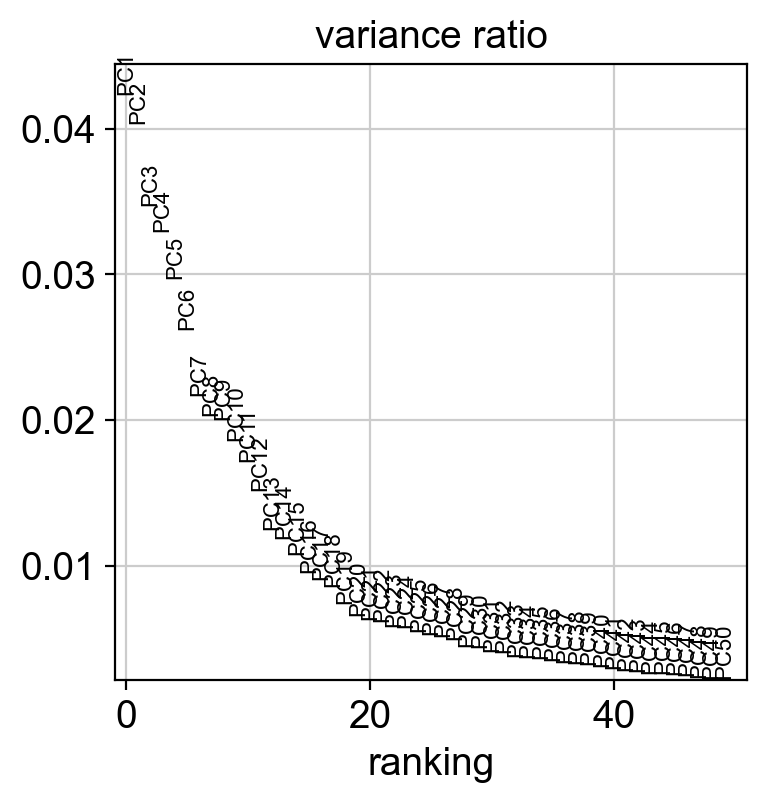

In [8]:
adata = adata_base.copy()

pr = True
adata = process_data(adata, pearson_residuals = pr, hv_subset = True)
adata = do_pca(adata,pearson_residuals = pr, n_comps =50)

## Clustering

In [ ]:
# Calculate kNN graph and perform Leiden clustering
adata.X = adata.layers['counts'].copy()
sc.pp.neighbors(adata, n_pcs=25)
sc.tl.leiden(adata)#, resolution=0.02)

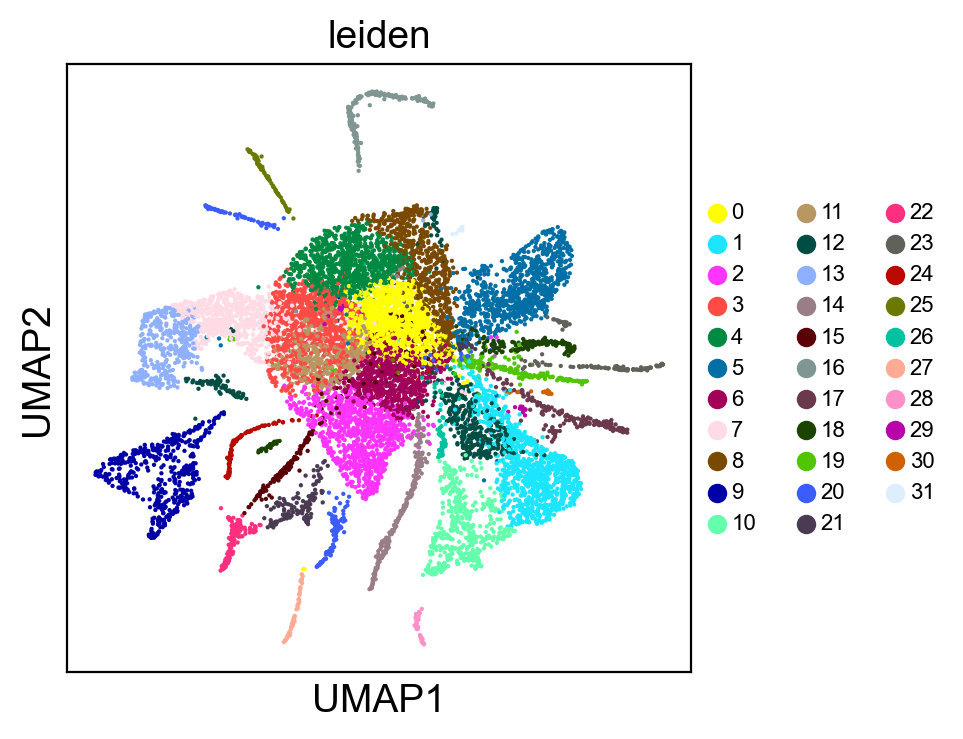

In [10]:
# Calculate UMAP
sc.tl.umap(adata)
sc.pl.umap(adata, color=['leiden'], legend_fontsize=8)

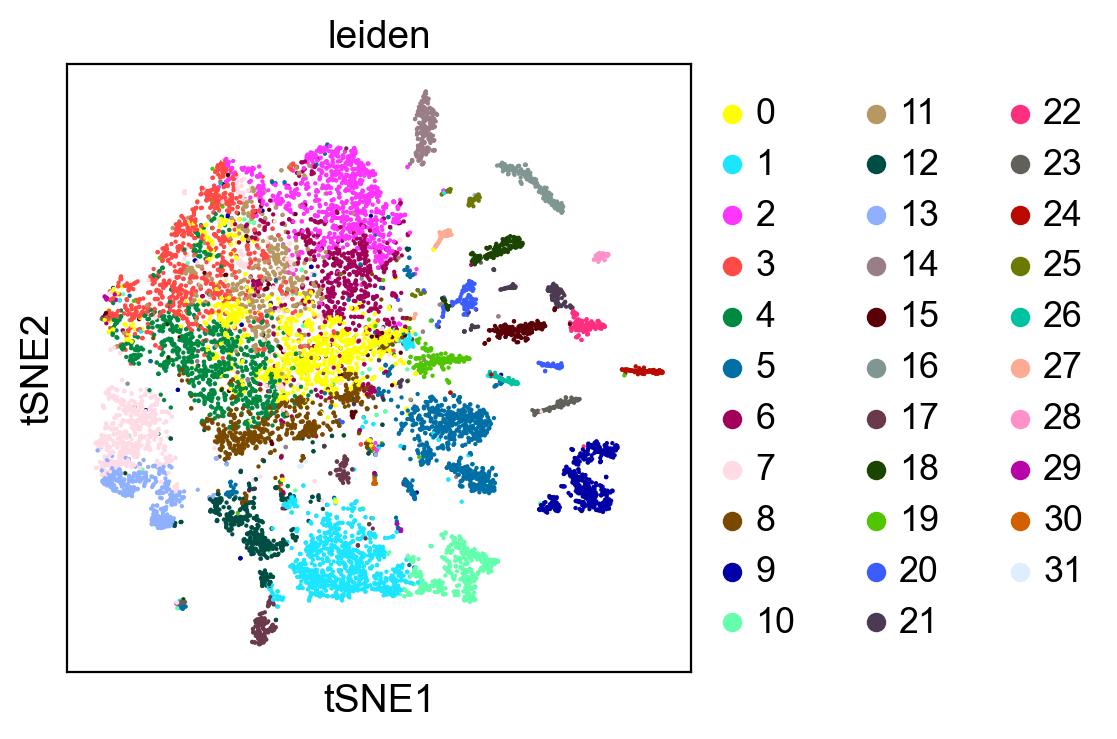

In [11]:
# Calculate TSNE
#sc.tl.tsne(adata, n_pcs=15, perplexity=30)
sc.tl.tsne(adata, use_rep="X_pca")
sc.pl.tsne(adata, color=["leiden"])

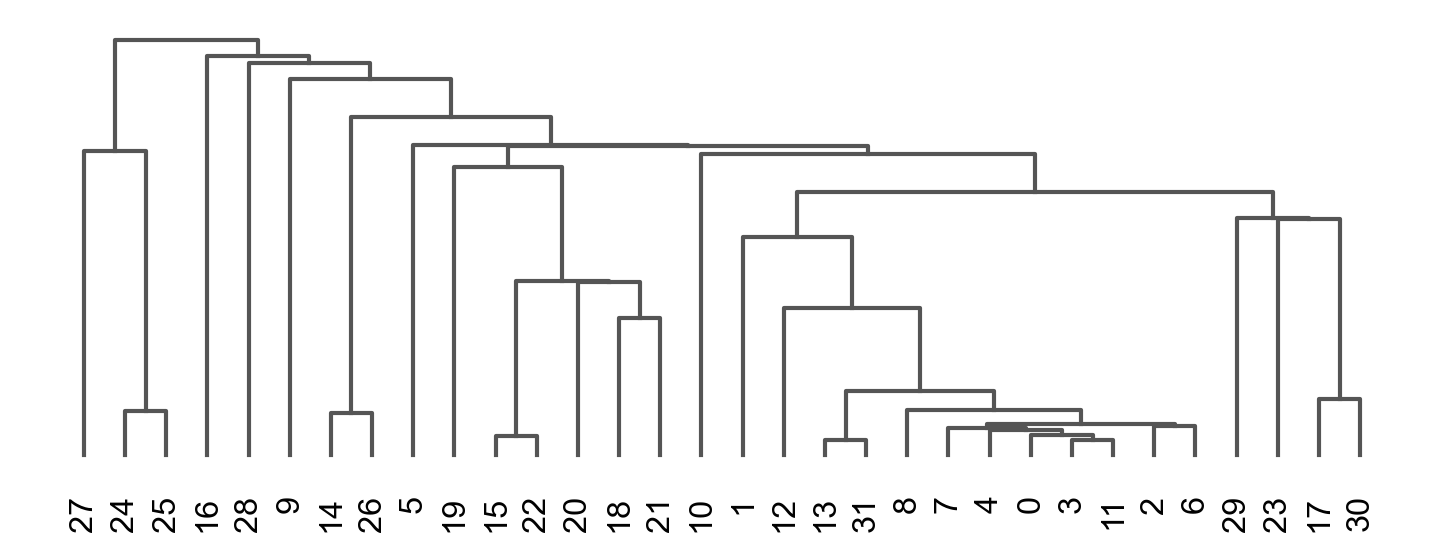

<Axes: >

In [12]:
sc.tl.dendrogram(adata, groupby='leiden', n_pcs=15, use_rep='X_pca',
                 linkage_method='single')
fig, ax = plt.subplots(1, 1, figsize=[9, 3])
sc.pl.dendrogram(adata, groupby='leiden', ax=ax)

# clustering with Z-score

c:\Users\svk\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_scale.py:299: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


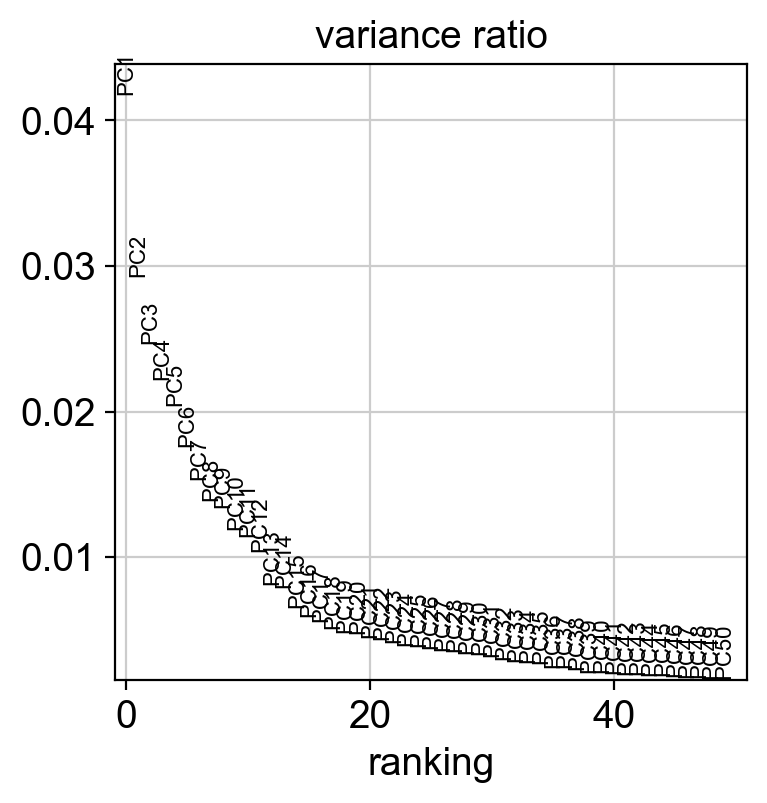

In [18]:
adata = adata_base.copy()

pr = False
adata = process_data(adata, pearson_residuals = pr, hv_subset = True)
adata = do_pca(adata,pearson_residuals = pr, n_comps =50)

## Clustering

In [19]:
# Calculate kNN graph and perform Leiden clustering
adata.X = adata.layers['counts'].copy()
sc.pp.neighbors(adata, n_pcs=25)
sc.tl.leiden(adata)#, resolution=0.02)

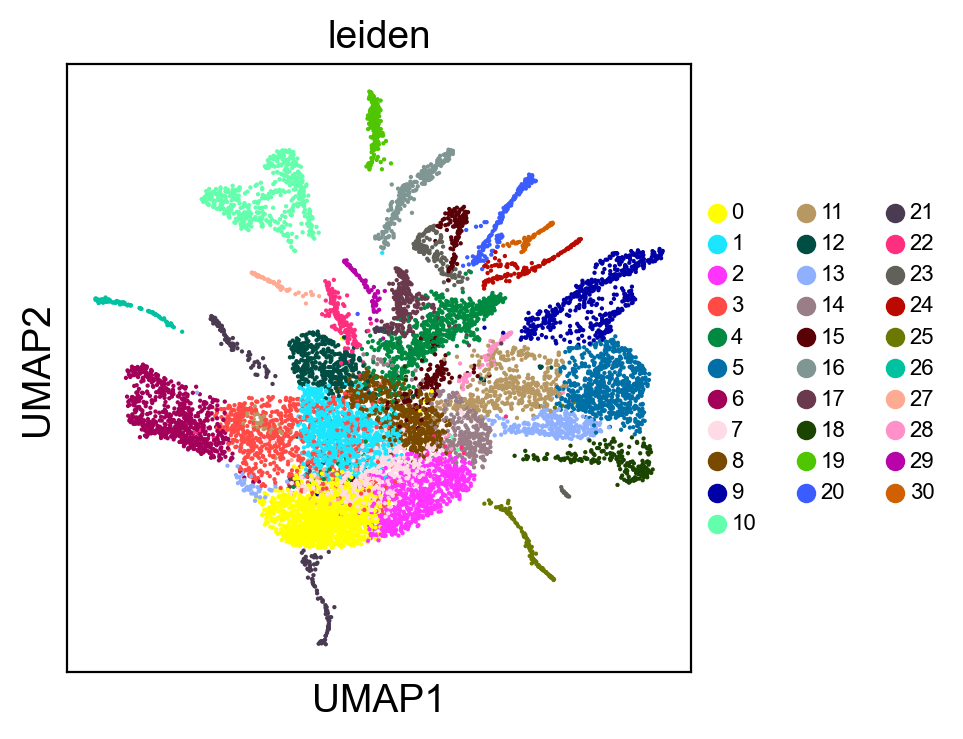

In [20]:
# Calculate UMAP
sc.tl.umap(adata)
sc.pl.umap(adata, color=['leiden'], legend_fontsize=8)

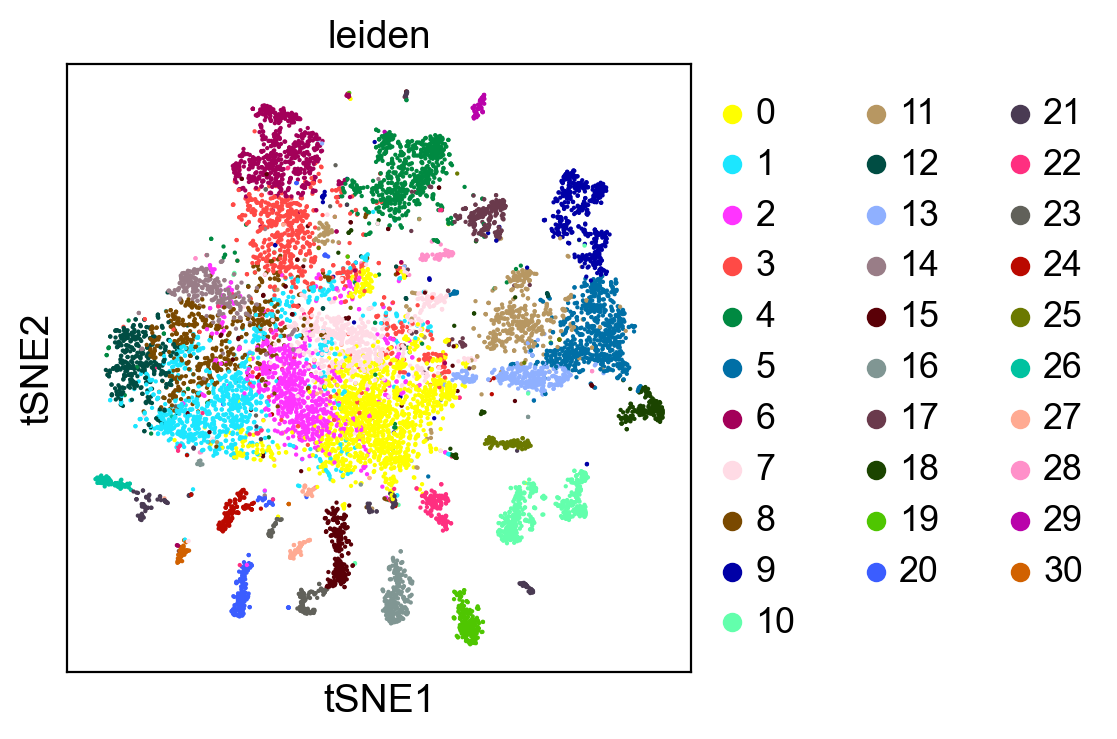

In [21]:
# Calculate TSNE
#sc.tl.tsne(adata, n_pcs=15, perplexity=30)
sc.tl.tsne(adata, use_rep="X_pca")
sc.pl.tsne(adata, color=["leiden"])

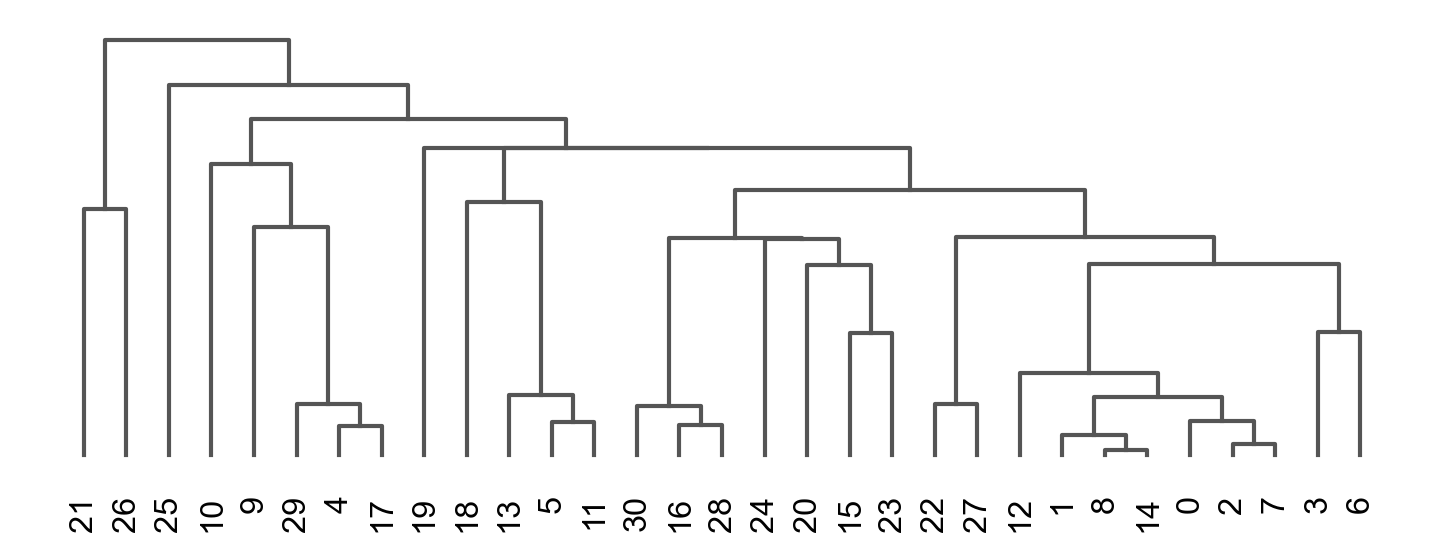

<Axes: >

In [22]:
sc.tl.dendrogram(adata, groupby='leiden', n_pcs=15, use_rep='X_pca',
                 linkage_method='single')
fig, ax = plt.subplots(1, 1, figsize=[9, 3])
sc.pl.dendrogram(adata, groupby='leiden', ax=ax)